In [10]:
import bz2
import pickle
import _pickle as cPickle
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import os
import trimesh
import pydot
from networkx.drawing.nx_agraph import graphviz_layout
import numpy as np

In [2]:
def extract_pbz2(file_path):
    try:
        with open(file_path, 'rb') as f_in:
            compressed_data = f_in.read()

            # Decompress the data
            decompressed_data = bz2.decompress(compressed_data)

            # Unpickle the decompressed data
            unpickled_object = pickle.loads(decompressed_data)

            return unpickled_object
    except FileNotFoundError:
        return None
    except OSError as e:
        print(f"Error: {e}")
        return None
    except pickle.UnpicklingError as e:
        print(f"Error while unpickling: {e}")
        return None
    
def visualize_digraph(graph):
    pos = graphviz_layout(graph, prog="dot")
    nx.draw(graph, pos)
    plt.show()

In [3]:
manual_labels = pd.read_csv("../cell_types.csv")
manual_labels

Unnamed: 0          pt_root_id  cell_id m_type cell_type_manual  \
0              0  864691135687112672   262825    L4c               4P   
1              1  864691135162584621   298868    L4a            5P-IT   
2              2  864691135988284416   298828    L4a            5P-IT   
3              3  864691135476384680   298945    L4a            5P-IT   
4              4  864691135590240523   299071    L4c            5P-IT   
...          ...                 ...      ...    ...              ...   
1341        1341  864691135058985115   269585    DTC               MC   
1342        1342  864691135468031628   307287    DTC         Unsure I   
1343        1343  864691135355455183   307126    STC         Unsure I   
1344        1344  864691136118890776   305048    PTC               BC   
1345        1345  864691136273370302   303236    DTC              NGC   

      pt_position_um_x  pt_position_um_y  pt_position_um_z  
0           648.871757        374.743206            857.12  
1           658.495023        377.833689            871.28  
2           702.888652        382.231584            816.16  
3           695.170942        382.327305            864.80  
4           684.634392        381.598210            898.24  
...                ...               ...               ...  
1341        611.953530        508.867955            919.80  
1342        651.601783        627.719795            974.16  
1343        671.966250        616.716806            908.88  
1344        663.755799        526.248960            889.12  
1345        690.926918        502.799849            907.12  

[1346 rows x 8 columns]

In [4]:
# Copy the relevant skeletons from the server
#skeleton_dir = "workstation:/usr/users/agecker/datasets/neuron_morphology_baylor/graph_objects/v7"
#for cell_id in pd.read_csv("../cell_types.csv")["pt_root_id"]:
#    file_name = f"{skeleton_dir}/{cell_id}_0_auto_proof_v7_proofread.pbz2"
#    !scp {file_name} .

In [5]:
cell_ids = pd.read_csv("../cell_types.csv")["pt_root_id"]
n_relevant_skeletons = len(list(filter(lambda x: x.endswith(".pbz2"), os.listdir("."))))
print(f"{n_relevant_skeletons} skeletons of {len(cell_ids)} labelled neurons are relevant ({n_relevant_skeletons / len(cell_ids) * 100}%)")

899 skeletons of 1346 labelled neurons are relevant (66.79049034175334%)


In [6]:
# For each neuron, calculate how many edges are covered by the recursion depth
def coverage_of_rec_depth(skeleton, depth_limit=4):
    return len(list(nx.bfs_edges(skeleton, "S0", depth_limit=depth_limit))) / len(list(nx.bfs_edges(skeleton, "S0")))

def find_deepest_node(graph, node):
    # Find the deepest node in the graph
    depths = nx.shortest_path_length(graph, source=node)
    deepest_node = max(depths, key=depths.get)
    return deepest_node

def edge_collapse(graph, node_s):
    deepest_node = find_deepest_node(graph, node_s)
    
    # Find shortest path to node_s
    shortest_path = nx.shortest_path(graph, source=node_s, target=deepest_node)
    
    # Remove all nodes on the shortest path except node_s
    nodes_to_remove = [node for node in shortest_path if node != node_s]
    graph.remove_nodes_from(nodes_to_remove)
    
    # Attach any nodes now left without a parent to node_s
    for node in graph.nodes():
        if node != node_s and len(list(graph.predecessors(node))) == 0:
            graph.add_edge(node_s, node)
            
def represent_as_branches(graph):
    edge_collapse(graph, "S0")
    for desc in nx.descendants_at_distance(graph, "S0", 1):
        edge_collapse(graph, desc)
    for desc in nx.descendants_at_distance(graph, "S0", 2):
        edge_collapse(graph, desc)
    return graph
                                                                        
def perc_covered_by_alg(skeleton):
    branch_graph = represent_as_branches(skeleton)
    return coverage_of_rec_depth(skeleton, depth_limit=3)

In [7]:
used_cell_ids = []
perc_covered = []
for cell_id in cell_ids:
    file_name = f"{cell_id}_0_auto_proof_v7_proofread.pbz2"
    skeleton = extract_pbz2(file_name)
    if not skeleton:
        continue
    used_cell_ids.append(cell_id)
    perc_covered.append(perc_covered_by_alg(skeleton))

In [8]:
coverage = pd.DataFrame({"pt_root_id": used_cell_ids, "perc_covered": perc_covered})
coverage = coverage.merge(manual_labels)[["pt_root_id", "perc_covered", "cell_type_manual"]]

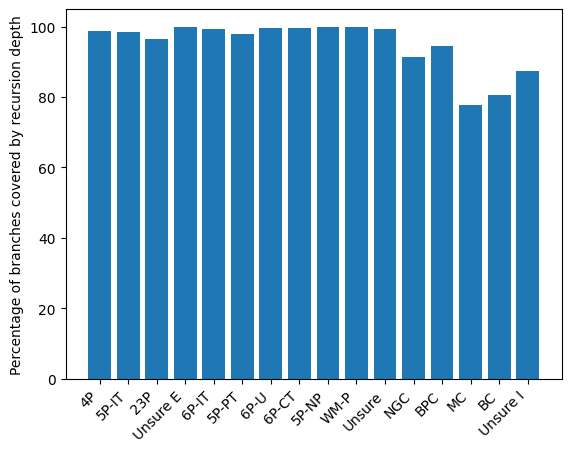

In [13]:
# Calculate average coverage per type
counts = {}
cov_per_type = {}
for _, row in coverage.iterrows():
    type = row.iloc[2]
    if not type in counts:
        counts[type] = 0
    if not type in cov_per_type:
        cov_per_type[type] = 0
    cov_per_type[type] = (counts[type] * cov_per_type[type] + row.iloc[1]) / (counts[type] + 1)
    counts[type] += 1
    
plt.bar(cov_per_type.keys(), np.array(list(cov_per_type.values())) * 100)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Percentage of branches covered by recursion depth")
plt.savefig("recursion_coverage.png")
plt.show()